In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark


#REGRESION LOGISTICA

Área bajo la curva Precision-Recall: 0.96
AUC del modelo: 0.75
Precisión del modelo: 0.90


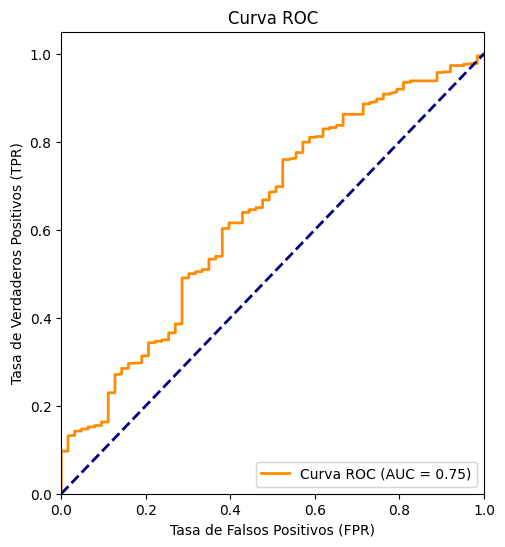

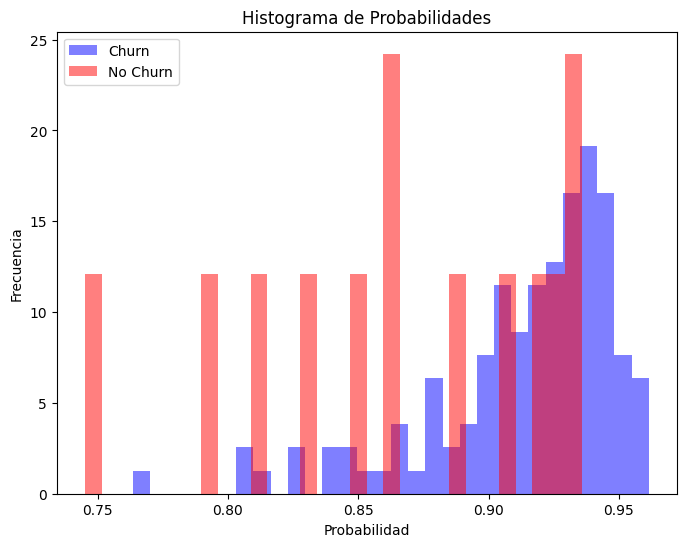

In [62]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col

# Crear una sesión de Spark
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()
path = "/content/drive/MyDrive/COLAB-DIPLOMADO/credit_card_candidate_churn_y.csv"

# Cargar el conjunto de datos desde un archivo CSV
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir las características y la variable objetivo
feature_cols = ['amount', 'duration', 'payments']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Crear un modelo de Regresión Logística
logistic_regression = LogisticRegression(labelCol="churn_y", featuresCol="features")

# Crear un pipeline para ensamblar y entrenar el modelo
pipeline = Pipeline(stages=[vector_assembler, logistic_regression])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo utilizando el AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="churn_y")
auc = evaluator_auc.evaluate(predictions)

# Evaluar el modelo utilizando la precisión
evaluator_precision = MulticlassClassificationEvaluator(labelCol="churn_y", metricName="accuracy")
precision = evaluator_precision.evaluate(predictions)

# Calcular de la Precision-Recall
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_precision_recall = BinaryClassificationEvaluator(labelCol="churn_y", metricName="areaUnderPR")
precision_recall = evaluator_precision_recall.evaluate(predictions)

# Imprimir el valor del área bajo la curva PR (Precision-Recall)
print(f"Área bajo la curva Precision-Recall: {precision_recall:.2f}")


# Imprimir el resultado del AUC y la precisión
print(f"AUC del modelo: {auc:.2f}")
print(f"Precisión del modelo: {precision:.2f}")

# Obtener las tasas de falsos positivos (FPR) y verdaderos positivos (TPR)
roc = model.stages[-1].summary.roc.toPandas()
fpr = roc['FPR']
tpr = roc['TPR']

# Graficar la curva ROC
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Calcular la puntuación de precisión promedio
evaluator_avg_precision = MulticlassClassificationEvaluator(labelCol="churn_y", metricName="weightedPrecision")
average_precision = evaluator_avg_precision.evaluate(predictions)



# Histograma de probabilidades

plt.figure(figsize=(8, 6))
plt.hist(predictions.filter(col("churn_y") == 1).select("probability").rdd.map(lambda x: x[0][1]).collect(), bins=30, color='blue', alpha=0.5, label='Churn', density=True)
plt.hist(predictions.filter(col("churn_y") == 0).select("probability").rdd.map(lambda x: x[0][1]).collect(), bins=30, color='red', alpha=0.5, label='No Churn', density=True)
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Probabilidades')
plt.legend()
plt.show()



# Detener la sesión de Spark
spark.stop()




#RANDOM FOREST

AUC del modelo: 0.77
Precisión del modelo: 0.90


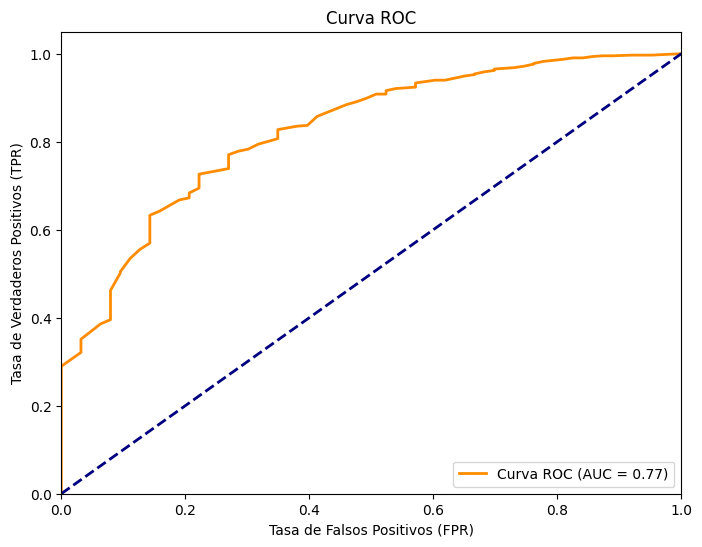

In [ ]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Crear una sesión de Spark
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()
path = "/content/drive/MyDrive/COLAB-DIPLOMADO/credit_card_candidate_churn_y.csv"

# Cargar el conjunto de datos desde un archivo CSV
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir las características y la variable objetivo
feature_cols = ['amount', 'duration', 'payments']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Crear un modelo de Random Forest
rf_model = RandomForestClassifier(labelCol="churn_y", featuresCol="features")

# Crear un pipeline para ensamblar y entrenar el modelo
pipeline = Pipeline(stages=[vector_assembler, rf_model])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo utilizando el AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="churn_y")
auc = evaluator_auc.evaluate(predictions)

# Evaluar el modelo utilizando la precisión
evaluator_precision = MulticlassClassificationEvaluator(labelCol="churn_y", metricName="accuracy")
precision = evaluator_precision.evaluate(predictions)

# Imprimir el resultado del AUC y la precisión
print(f"AUC del modelo: {auc:.2f}")
print(f"Precisión del modelo: {precision:.2f}")

# Obtener las tasas de falsos positivos (FPR) y verdaderos positivos (TPR)
roc = model.stages[-1].summary.roc.toPandas()
fpr = roc['FPR']
tpr = roc['TPR']

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Detener la sesión de Spark
spark.stop()


#REDES NEURONALES ARTIFICIALES

In [ ]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Crear una sesión de Spark
spark = SparkSession.builder.appName("NeuralNetworkExample").getOrCreate()
path = "/content/drive/MyDrive/COLAB-DIPLOMADO/credit_card_candidate_churn_y.csv"

# Cargar el conjunto de datos desde un archivo CSV
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir las características y la variable objetivo
feature_cols = ['amount', 'duration', 'payments']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Crear un modelo de Red Neuronal Artificial (RNA)
layers = [len(feature_cols), 5, 2, 2]  # Definir la arquitectura de la RNA (entradas, capas ocultas y salidas)
rna_model = MultilayerPerceptronClassifier(labelCol="churn_y", featuresCol="features", layers=layers)

# Crear un pipeline para ensamblar y entrenar el modelo
pipeline = Pipeline(stages=[vector_assembler, rna_model])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo utilizando el AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="churn_y")
auc = evaluator_auc.evaluate(predictions)

# Evaluar el modelo utilizando la precisión
evaluator_precision = MulticlassClassificationEvaluator(labelCol="churn_y", metricName="accuracy")
precision = evaluator_precision.evaluate(predictions)

# Imprimir el resultado del AUC y la precisión
print(f"AUC del modelo: {auc:.2f}")
print(f"Precisión del modelo: {precision:.2f}")

# Obtener las tasas de falsos positivos (FPR) y verdaderos positivos (TPR)
predictions = model.transform(test_data)
y_prob = predictions.select("churn_y", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["churn_y"])))

# Detener la sesión de Spark
spark.stop()


AUC del modelo: 0.50
Precisión del modelo: 0.90


#ARBOL DE DESICIONES

In [ ]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Crear una sesión de Spark
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()
path = "/content/drive/MyDrive/COLAB-DIPLOMADO/credit_card_candidate_churn_y.csv"

# Cargar el conjunto de datos desde un archivo CSV
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir las características y la variable objetivo
feature_cols = ['amount', 'duration', 'payments']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Crear un modelo de Árbol de Decisión
dt_model = DecisionTreeClassifier(labelCol="churn_y", featuresCol="features")

# Crear un pipeline para ensamblar y entrenar el modelo
pipeline = Pipeline(stages=[vector_assembler, dt_model])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo utilizando el AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="churn_y")
auc = evaluator_auc.evaluate(predictions)

# Imprimir el resultado del AUC
print(f"AUC del modelo: {auc:.2f}")
print(f"Precisión del modelo: {precision:.2f}")

spark.stop()


AUC del modelo: 0.67
Precisión del modelo: 0.90
